In [82]:
import numpy as np
from numpy.random import exponential
import matplotlib.pyplot as plt

## Idea

* Simulate as close to our model as possible to check math, use SLiM to check robustness
* Branching process simulatinos using Gillespie algorithm
* Main model params: birth rate 1-s, death rate 1, mutation rate $\mu$

### Algorithm sketch - without space

1. Initialize system with no lineages present (k=0)
2. Draw time to first mutation from Exp($\mu$) & update k=1 
3. Draw time to next event from Exp(k(1-s)+k+$\mu$)
4. Draw which event type occurs (using prob. from competing exponentials)
5. Update system accordingly
6. Repeat 3-5 until some stopping condition met

### Algorithm sketch - with space

1. Initialize system with no lineages present (k=0, size LxL)
2. Draw time to first mutation from Exp($\mu$) & update k=1, assign location at random
3. Draw time to next event from Exp(k(1-s)+k+$\mu$)
4. Add Gaussian noise to locations of all alive individuals with standard dev. $\sigma$
5. Draw event type as before
6. Update system
7. Repeat 3-6 until some stopping condition met

### To be added

* Periodic boundary conditions
* Gaussian noise should be dependent on waiting time
* Sampling - uniform and spatial
    * Spatial - sample from center of habitat, vary width $w$
    * Need to work out sampling probabilities - possibly Bernoulli for each carrier w/ probabilties depending on Gaussian weights?

### Questions

* Tracking mutation type/lineage?
* Previously had versions similar to this with "implicit $\mu$" and one mutation at a time - fine to do it this way, or was there a strong reason?


## No space

In [46]:
def time_to_next(k,s,mu):
    return exponential(k*(1-s)+k+mu)

def choose_event(k,s,mu):
    tot = k*(1-s)+k+mu
    event = np.random.choice(['b','d','m'],p=[(k*(1-s)/tot),(k/tot),(mu/tot)])
    return event # 0=birth, 1=death

In [59]:
choose_event(1,0.1,1e-3)

'd'

In [79]:
def run_sim(s,mu,N): # N total number of events
    counts = np.zeros((N+1, 2)) # store counts and time since last event, first row 0s
    counter = 1
    while counter <= N:
        # time to next event
        k = counts[counter-1,1] # number particles
        t_next = time_to_next(k,s,mu)
        counts[counter,0]=counts[counter-1,0]+t_next # update time
        # choose event time and update
        e_type = choose_event(k,s,mu)
        if e_type in ['b','m']:
            counts[counter,1] = counts[counter-1,1]+1 # update count
        elif e_type in ['d']:
            counts[counter,1] = counts[counter-1,1]-1 # update count
        counter+=1
    return counts

In [80]:
np.random.seed(2024)

sim_df = run_sim(1e-2,1e-3,10)

In [81]:
sim_df

array([[0.00000000e+00, 0.00000000e+00],
       [8.86767170e-04, 1.00000000e+00],
       [4.15894987e-01, 2.00000000e+00],
       [1.32928370e+00, 3.00000000e+00],
       [9.08658907e+00, 2.00000000e+00],
       [1.16430311e+01, 3.00000000e+00],
       [1.17582227e+01, 2.00000000e+00],
       [1.54304201e+01, 1.00000000e+00],
       [1.76040782e+01, 0.00000000e+00],
       [1.76046745e+01, 1.00000000e+00],
       [1.98130736e+01, 0.00000000e+00]])

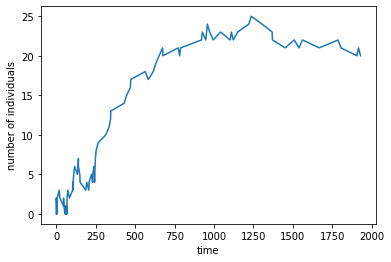

In [89]:
sim_df = run_sim(1e-2,1e-8,100)
plt.plot(sim_df[:,0],sim_df[:,1])
plt.xlabel("time")
plt.ylabel("number of individuals")
plt.show()

## Add Space

In [140]:
def run_sim_spatial(s,mu,sigma,N,max_ind,L=50):
    # keep track of counts (like non spatial)
    counts = np.zeros((N+1, 2)) # [time, counts]
    counter = 1 #initialize at 1
    # keep track of locations
    
    ind_data = np.zeros((N+1, max_ind, 5)) # one table per event + initialize
    # [alive/dead, x coord, y coord, time @ birth, time @ death]
    
    while counter <= N:
        # time to next event
        k = counts[counter-1,1] # number particles
        t_next = time_to_next(k,s,mu)
        e_type = choose_event(k,s,mu)
        
        #update counts
        counts[counter,0]=counts[counter-1,0]+t_next # update time
        if e_type in ['b','m']:
            counts[counter,1] = counts[counter-1,1]+1 # update count
        elif e_type in ['d']:
            counts[counter,1] = counts[counter-1,1]-1 # update count
        
        # update ind_data
        
        ### update spatial coordinates
        ind_data[counter] = ind_data[counter-1]
        indices = np.where(ind_data[counter, :, 0] == 1)[0]
        if len(indices)>0:
            ind_data[counter, indices, 1] += np.random.normal(loc=0, scale=0.2, size=len(indices)) # update x
            ind_data[counter, indices, 2] += np.random.normal(loc=0, scale=0.2, size=len(indices)) # update y

        ### mutation
        if e_type == 'm':
            # find next empty row
            empty_row_indices = np.where(np.all(ind_data[counter] == 0, axis=1))[0]
            if len(empty_row_indices)>0:
                next_row = empty_row_indices[0]
            else:
                print("ERROR: ran out of room in array!")
                break
            ind_data[counter, next_row] = [1,np.random.uniform(0,L),np.random.uniform(0,L),counts[counter,0],0]
        elif e_type == 'd':
            ## choose individual who dies
            indices = np.where(ind_data[counter, :, 0] == 1)
            random_index = np.random.choice(indices[0])
            ind_data[counter,random_index,0] = 0
            ind_data[counter,random_index,4] = counts[counter,0]
        elif e_type == 'b':
            empty_row_indices = np.where(np.all(ind_data[counter] == 0, axis=1))[0]
            if len(empty_row_indices)>0:
                next_row = empty_row_indices[0]
            else:
                print("ERROR: ran out of room in array!")
                break
            # choose parent
            indices = np.where(ind_data[counter, :, 0] == 1)
            random_index = np.random.choice(indices[0])
            ind_data[counter, next_row] = [1,ind_data[counter,random_index,1],ind_data[counter,random_index,2],counts[counter,0],0]

        # update counter
        counter+=1
        
        
    return counts,ind_data


In [141]:
counts,df = run_sim_spatial(1e-2,1e-8,0.2,20,100)

In [142]:
counts

array([[0.00000000e+00, 0.00000000e+00],
       [4.56210536e-09, 1.00000000e+00],
       [3.49029585e-01, 0.00000000e+00],
       [3.49029601e-01, 1.00000000e+00],
       [1.83515811e+00, 2.00000000e+00],
       [5.32028605e+00, 1.00000000e+00],
       [5.51797531e+00, 2.00000000e+00],
       [8.45793189e+00, 3.00000000e+00],
       [1.48334812e+01, 4.00000000e+00],
       [1.50689441e+01, 5.00000000e+00],
       [2.01419202e+01, 4.00000000e+00],
       [2.53534618e+01, 3.00000000e+00],
       [3.23004455e+01, 4.00000000e+00],
       [3.71481326e+01, 5.00000000e+00],
       [3.76530767e+01, 6.00000000e+00],
       [4.14800662e+01, 7.00000000e+00],
       [4.31386386e+01, 8.00000000e+00],
       [4.95845033e+01, 9.00000000e+00],
       [5.14354402e+01, 1.00000000e+01],
       [9.27923017e+01, 9.00000000e+00],
       [9.61947221e+01, 8.00000000e+00]])

In [148]:
df[10]

array([[0.00000000e+00, 2.00500568e+01, 1.26682331e+01, 4.56210536e-09,
        3.49029585e-01],
       [1.00000000e+00, 1.75582845e+01, 4.51398748e+01, 3.49029601e-01,
        0.00000000e+00],
       [0.00000000e+00, 1.68388468e+01, 4.43518656e+01, 1.83515811e+00,
        5.32028605e+00],
       [0.00000000e+00, 1.69899835e+01, 4.60410440e+01, 5.51797531e+00,
        2.01419202e+01],
       [1.00000000e+00, 1.68896004e+01, 4.45163543e+01, 8.45793189e+00,
        0.00000000e+00],
       [1.00000000e+00, 1.69563991e+01, 4.50295055e+01, 1.48334812e+01,
        0.00000000e+00],
       [1.00000000e+00, 1.72228702e+01, 4.51664086e+01, 1.50689441e+01,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.0000

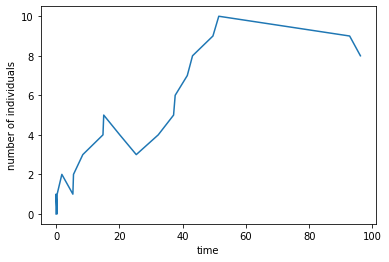

In [144]:
plt.plot(counts[:,0],counts[:,1])
plt.xlabel("time")
plt.ylabel("number of individuals")
plt.show()

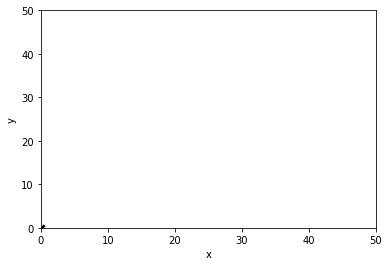

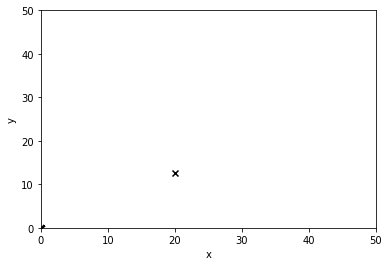

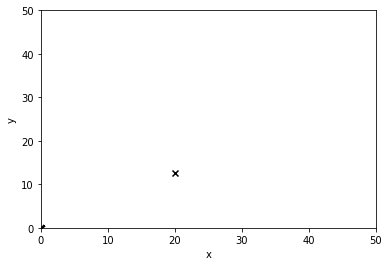

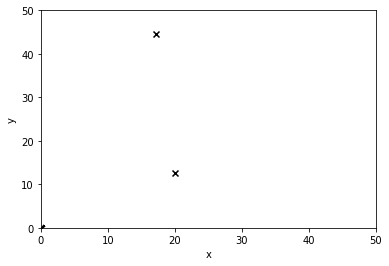

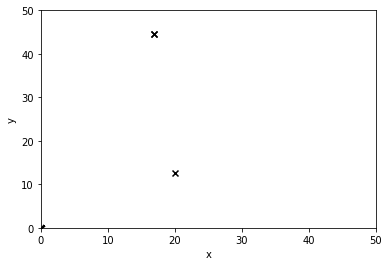

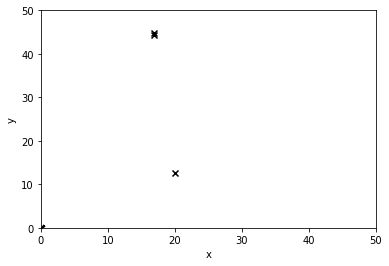

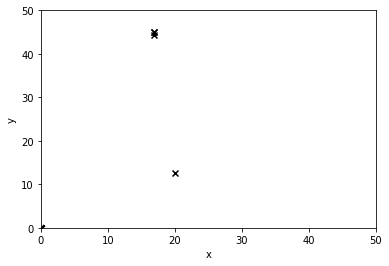

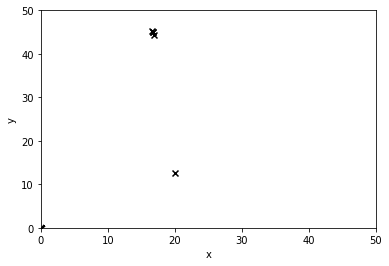

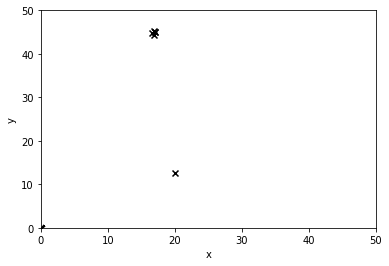

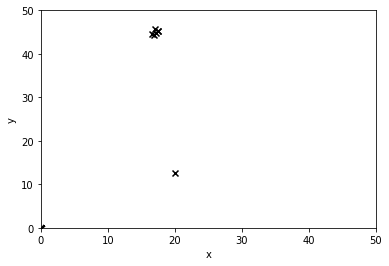

In [145]:
for i in range(10):
    plt.scatter(df[i,:,1],df[i,:,2],marker='x',color='black')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(0,50)
    plt.ylim(0,50)
    plt.show()